In [1]:
# Importar de librerias para la construccion del modelo: TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, Sequential, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Librerías para preprocesamiento y métricas
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import time

In [2]:
# Configuración de TensorFlow
print("Versión de TensorFlow:", tf.__version__)
print("¿TensorFlow está usando GPU?")
print(tf.config.list_physical_devices('GPU'))

Versión de TensorFlow: 2.10.0
¿TensorFlow está usando GPU?
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Diccionario de rutas
data_paths = {
    "Mel-512": "D:\\Folder_Jupiter\\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-512",
    "Mel-1024": "D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-1024",
    "Mel-2048": "D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\DataSetImages\\Spectrograms\\Mel-2048",
    "Bump": "D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Bump",
    "Morlet": "D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Morlet"  
}

In [6]:
def load_and_preprocess_data(data_path, batch_size=50, img_size=(224, 224)):
    # Cargar datasets de entrenamiento y validación
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )
    raw_val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )

    # Extraer nombres de las clases
    class_names = raw_train_ds.class_names

    # Normalizar los datos
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
    train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))

    # Prefetch para optimizar
    train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, class_names

In [7]:
print(data_paths)

{'Mel-512': 'D:\\Folder_Jupiter\\\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-512', 'Mel-1024': 'D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-1024', 'Mel-2048': 'D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Spectrograms\\Mel-2048', 'Bump': 'D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Bump', 'Morlet': 'D:\\Folder_Jupiter\\Analisis_Espectros\\DataSetImages_FULL\\DataSetImages\\Scalograms\\Morlet'}


In [8]:
def create_model(num_classes):
    # Cargar Resnet101 preentrenado
    base_model = ResNet101V2(
        weights="imagenet",        # Pesos preentrenados en ImageNet
        include_top=False,         # Excluir capas densas superiores
        input_shape=(224, 224, 3)  # Tamaño de entrada para Resnet101
    )
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),                 # Capa de agrupamiento
        layers.Dense(128, activation="relu"),            # Capa densa intermedia
        layers.Dropout(0.5),                             # Regularizacion
        layers.Dense(num_classes, activation="softmax")  # Capa de salida
    ])
    return model

In [9]:
# Función para entrenar el modelo (Transfer Learning)
def train_model(model, train_ds, val_ds, epochs=30):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

In [10]:
# Función para realizar Fine-Tuning
def fine_tune_model(model, train_ds, val_ds, base_learning_rate=1e-4, fine_tune_at=60, epochs=60):
    # Descongelar la base del modelo
    model.layers[0].trainable = True

    # Congelar las primeras capas segun sea necesario
    for layer in model.layers[0].layers[:fine_tune_at]:
        layer.trainable = False

    # Compilar el modelo para ajuste fino
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    # Usar callback de Early Stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)]

    #Entrenamiento con ajuste-fino
    history = model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=epochs,
        callbacks=callbacks
    )
    return history

In [11]:
def generate_classification_report(model, val_ds, class_names, title=""):
    y_true = []
    y_pred = []

    # Obtener predicciones
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(f"\nReporte de Clasificación para {title}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="magma", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return report

In [12]:
# Función para graficar métricas de entrenamiento
def plot_training_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))

        # Subplot para Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color='#1f77b4', linestyle='-', linewidth=2, label='Training Accuracy')  # Azul intenso
    plt.plot(epochs, val_acc, color='#ff7f0e', linestyle='--', linewidth=2, label='Validation Accuracy')  # Naranja
    plt.title(f'{title} - Training and Validation Accuracy', fontweight='bold')
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot para Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color='#2ca02c', linestyle='-', linewidth=2, label='Training Loss')  # Verde
    plt.plot(epochs, val_loss, color='#d62728', linestyle='--', linewidth=2, label='Validation Loss')  # Rojo
    plt.title(f'{title} - Training and Validation Loss', fontweight='bold')
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [13]:
# Funcion para medir el uso de CPU y memoria
def measure_system_load():
    cpu_usage = psutil.cpu_percent(interval=1)  #Procentaje de uso de CPU
    memory_usage = psutil.virtual_memory().percent # Porcentaje de uso de memoria
    return cpu_usage, memory_usage

In [14]:
def get_flops(model, input_shape=(1, 224, 224, 3)):
    # Crear funcion concreta de keras model
    input_tensor = tf.keras.Input(shape=input_shape[1:])
    dummy_model = Model(inputs=input_tensor, outputs=model(input_tensor))

    # Convertir a funcion concreta
    concrete_func = tf.function(lambda x: dummy_model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(input_shape, tf.float32)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph

    flops = 0
    for node in graph.get_operations():
        for output in node.outputs:
            flops += tf.math.reduce_prod(output.shape).numpy() if output.shape else 0
    return flops

In [15]:
# Lista para almacenar los tiempos de entrenamiento
training_times = []
# Lista para almacenar los resultados
final_results = []
# Lista para almacenar los resultados de carga computacional
computational_load = []


Procesando representación: Mel-512
Found 5363 files belonging to 7 classes.
Using 4291 files for training.
Found 5363 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Mel-512 (Transfer Learning): 147421488
Epoch 1/30
86/86 [==============================] - 58s 332ms/step - loss: 1.2981 - accuracy: 0.5244 - val_loss: 0.9227 - val_accuracy: 0.6810
Epoch 2/30
86/86 [==============================] - 22s 245ms/step - loss: 0.8856 - accuracy: 0.6914 - val_loss: 0.7584 - val_accuracy: 0.7463
Epoch 3/30
86/86 [==============================] - 21s 241ms/step - loss: 0.7514 - accuracy: 0.7376 - val_loss: 0.7007 - val_accuracy: 0.7668
Epoch 4/30
86/86 [==============================] - 22s 245ms/step - loss: 0.6598 - accuracy: 0.7700 - val_loss: 0.6164 - val_accuracy: 0.7948
Epoch 5/30
86/86 [==============================] - 22s 241ms/step - loss: 0.5931 - accuracy: 0.7933 - val_loss: 0.5978 - val_accuracy: 0.7910
Epoch 6/30
86/86 [==============================] - 2

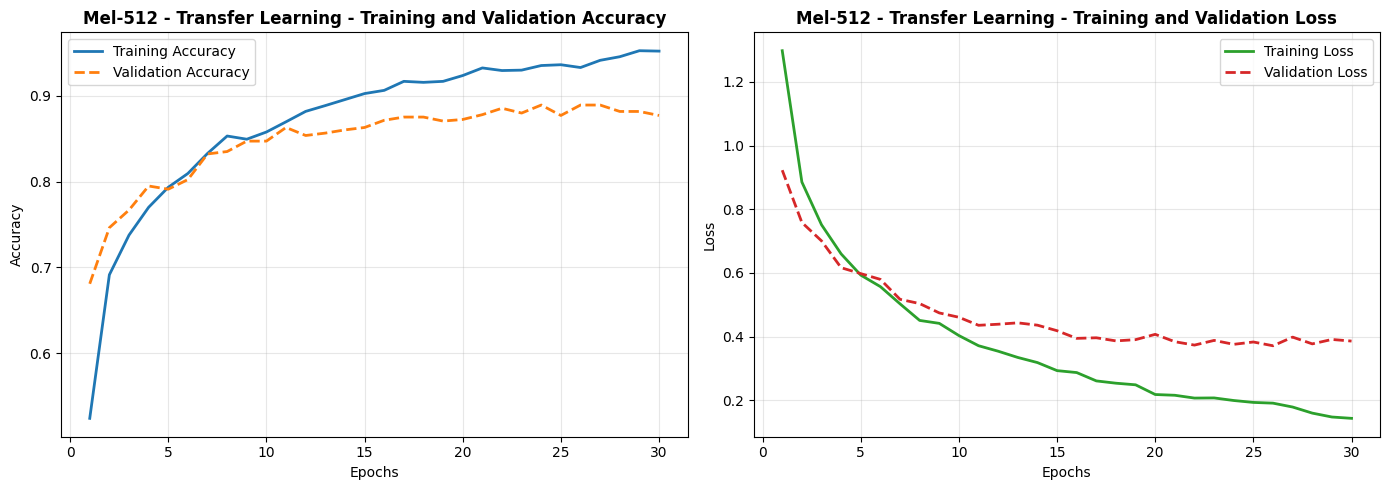

1/1 [==============================] - 0s 104ms/step

Reporte de Clasificación para Mel-512 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.82      0.96      0.88       143
children_playing       0.82      0.86      0.84       133
        drilling       0.89      0.88      0.88       168
   engine_idling       0.92      0.88      0.90       150
      jackhammer       0.92      0.88      0.90       156
           siren       0.94      0.87      0.90       161
    street_music       0.83      0.81      0.82       161

        accuracy                           0.88      1072
       macro avg       0.88      0.88      0.88      1072
    weighted avg       0.88      0.88      0.88      1072



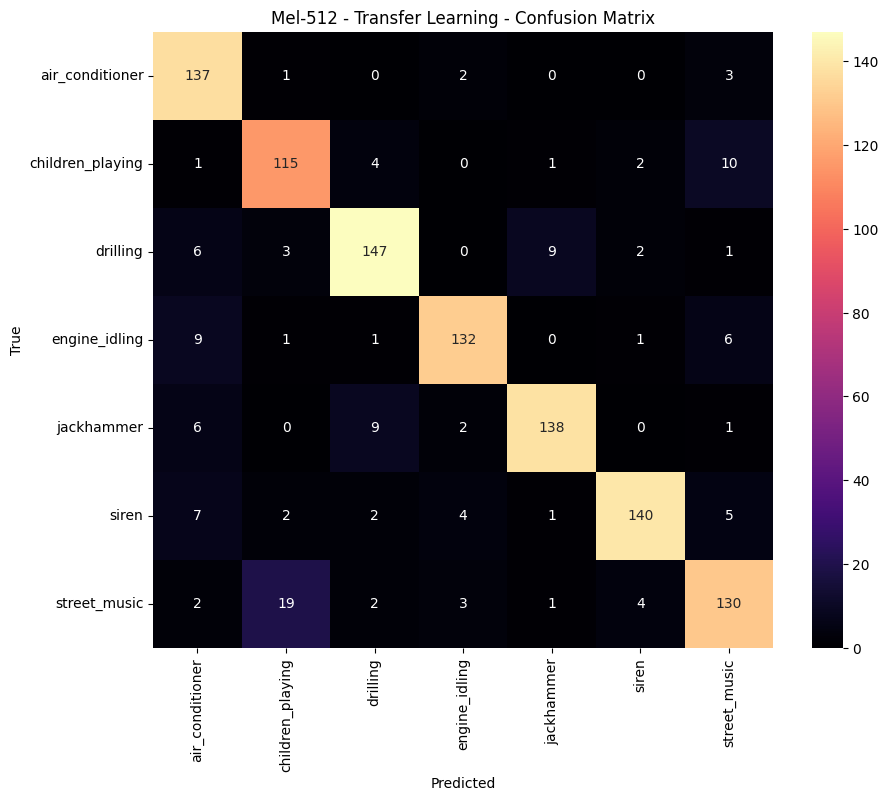

FLOPs para Mel-512 (Fine-Tuning): 147421488
Epoch 1/60
86/86 [==============================] - 92s 609ms/step - loss: 9.7551 - accuracy: 0.3330 - val_loss: 2.3272 - val_accuracy: 0.5774
Epoch 2/60
86/86 [==============================] - 44s 502ms/step - loss: 1.8946 - accuracy: 0.6546 - val_loss: 1.7954 - val_accuracy: 0.6539
Epoch 3/60
86/86 [==============================] - 44s 506ms/step - loss: 0.8227 - accuracy: 0.7656 - val_loss: 1.4358 - val_accuracy: 0.6866
Epoch 4/60
86/86 [==============================] - 44s 509ms/step - loss: 0.4850 - accuracy: 0.8378 - val_loss: 1.2794 - val_accuracy: 0.7034
Epoch 5/60
86/86 [==============================] - 44s 508ms/step - loss: 0.3020 - accuracy: 0.8923 - val_loss: 1.2354 - val_accuracy: 0.7080
Epoch 6/60
86/86 [==============================] - 44s 507ms/step - loss: 0.2074 - accuracy: 0.9259 - val_loss: 1.1892 - val_accuracy: 0.7229
Epoch 7/60
86/86 [==============================] - 45s 511ms/step - loss: 0.1558 - accuracy: 0.94

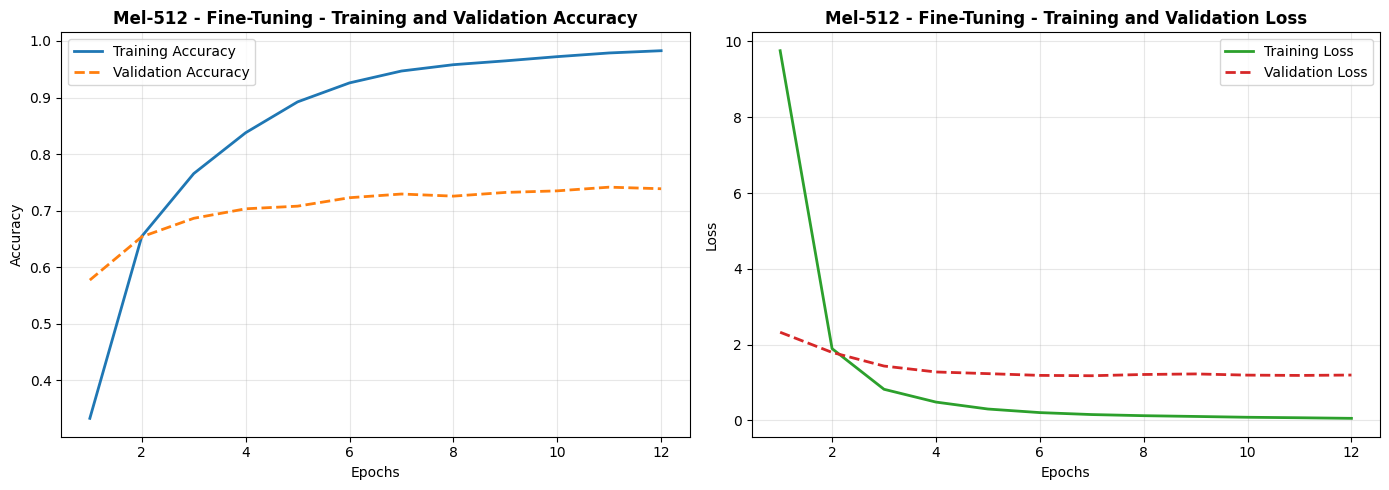

1/1 [==============================] - 0s 111ms/step

Reporte de Clasificación para Mel-512 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.71      0.78      0.74       143
children_playing       0.70      0.76      0.73       133
        drilling       0.70      0.70      0.70       168
   engine_idling       0.77      0.75      0.76       150
      jackhammer       0.76      0.76      0.76       156
           siren       0.79      0.77      0.78       161
    street_music       0.67      0.61      0.64       161

        accuracy                           0.73      1072
       macro avg       0.73      0.73      0.73      1072
    weighted avg       0.73      0.73      0.73      1072



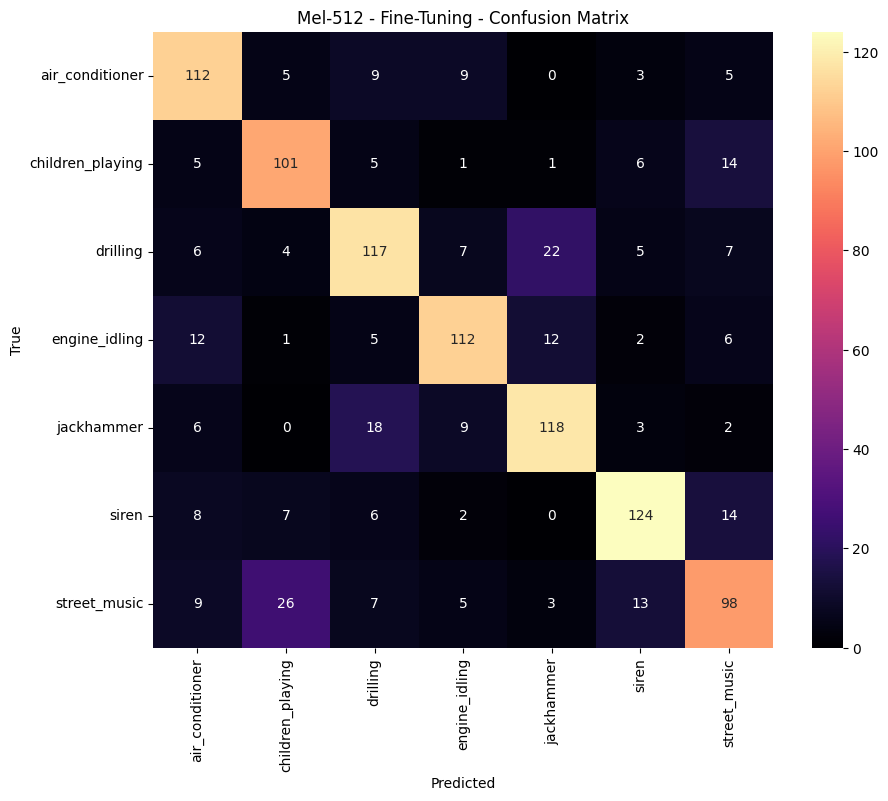

Tiempo Transfer Learning para Mel-512: 789.47 segundos
Tiempo Fine-Tuning para Mel-512: 639.84 segundos

Procesando representación: Mel-1024
Found 5363 files belonging to 7 classes.
Using 4291 files for training.
Found 5363 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Mel-1024 (Transfer Learning): 147421488
Epoch 1/30
86/86 [==============================] - 44s 317ms/step - loss: 1.2486 - accuracy: 0.5435 - val_loss: 0.8116 - val_accuracy: 0.7435
Epoch 2/30
86/86 [==============================] - 22s 243ms/step - loss: 0.8064 - accuracy: 0.7259 - val_loss: 0.6794 - val_accuracy: 0.7640
Epoch 3/30
86/86 [==============================] - 21s 242ms/step - loss: 0.6767 - accuracy: 0.7674 - val_loss: 0.6136 - val_accuracy: 0.7910
Epoch 4/30
86/86 [==============================] - 21s 243ms/step - loss: 0.5858 - accuracy: 0.8003 - val_loss: 0.5595 - val_accuracy: 0.8134
Epoch 5/30
86/86 [==============================] - 21s 242ms/step - loss: 0.5120 - accura

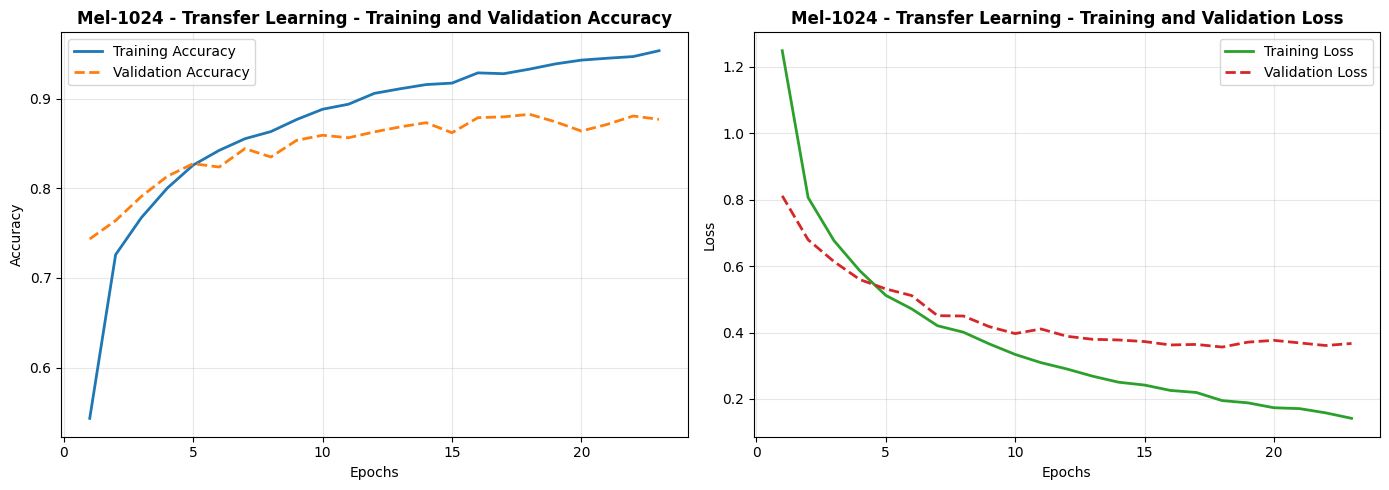

1/1 [==============================] - 0s 115ms/step

Reporte de Clasificación para Mel-1024 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.85      0.93      0.89       143
children_playing       0.88      0.85      0.87       133
        drilling       0.89      0.83      0.86       168
   engine_idling       0.94      0.89      0.91       150
      jackhammer       0.89      0.92      0.91       156
           siren       0.91      0.91      0.91       161
    street_music       0.82      0.84      0.83       161

        accuracy                           0.88      1072
       macro avg       0.88      0.88      0.88      1072
    weighted avg       0.88      0.88      0.88      1072



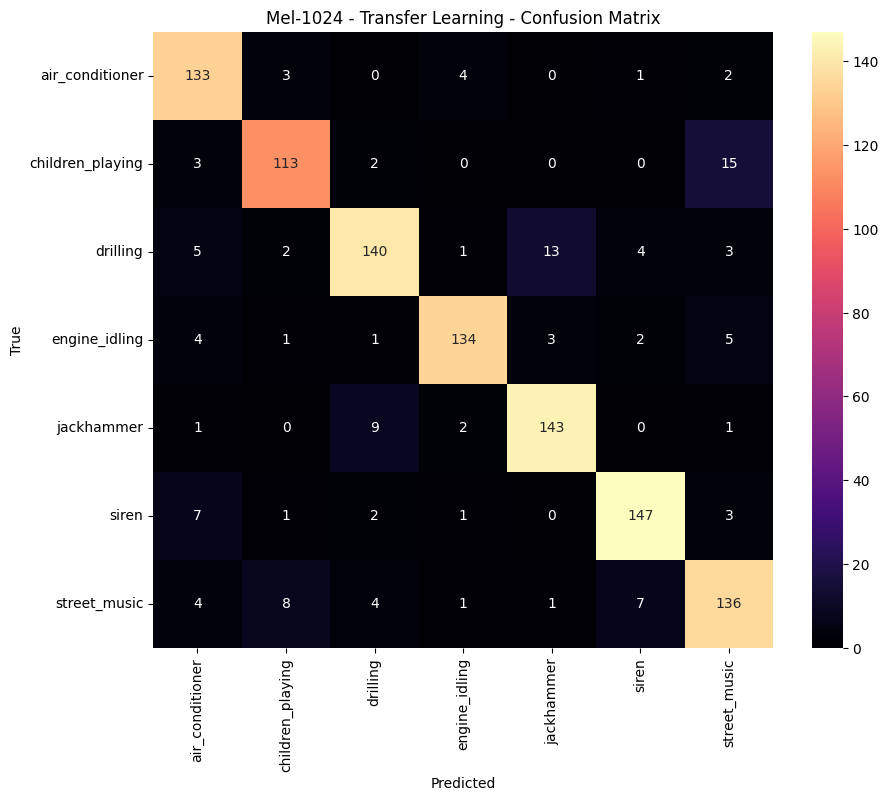

FLOPs para Mel-1024 (Fine-Tuning): 147421488
Epoch 1/60
86/86 [==============================] - 80s 581ms/step - loss: 5.4339 - accuracy: 0.3754 - val_loss: 1.5533 - val_accuracy: 0.6455
Epoch 2/60
86/86 [==============================] - 43s 493ms/step - loss: 1.0772 - accuracy: 0.7129 - val_loss: 1.0527 - val_accuracy: 0.7267
Epoch 3/60
86/86 [==============================] - 43s 493ms/step - loss: 0.5564 - accuracy: 0.8157 - val_loss: 0.8659 - val_accuracy: 0.7528
Epoch 4/60
86/86 [==============================] - 43s 492ms/step - loss: 0.3179 - accuracy: 0.8928 - val_loss: 0.7829 - val_accuracy: 0.7659
Epoch 5/60
86/86 [==============================] - 43s 493ms/step - loss: 0.2071 - accuracy: 0.9336 - val_loss: 0.7641 - val_accuracy: 0.7677
Epoch 6/60
86/86 [==============================] - 43s 493ms/step - loss: 0.1504 - accuracy: 0.9508 - val_loss: 0.7547 - val_accuracy: 0.7771
Epoch 7/60
86/86 [==============================] - 43s 492ms/step - loss: 0.1041 - accuracy: 0.9

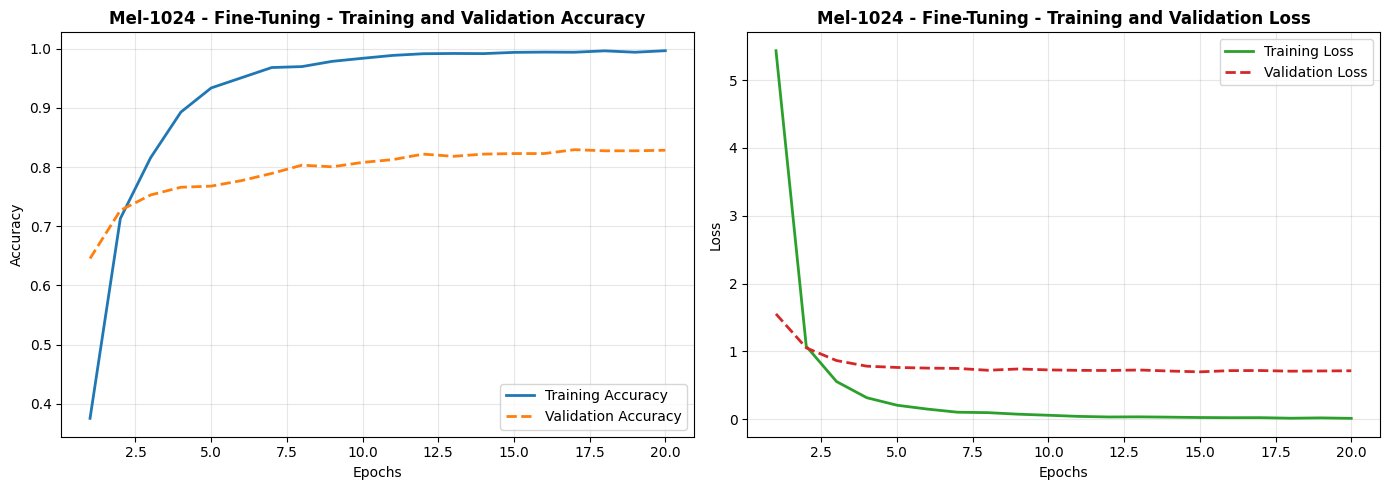

1/1 [==============================] - 0s 114ms/step

Reporte de Clasificación para Mel-1024 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.81      0.82      0.82       143
children_playing       0.78      0.77      0.78       133
        drilling       0.80      0.83      0.82       168
   engine_idling       0.85      0.82      0.83       150
      jackhammer       0.85      0.90      0.87       156
           siren       0.86      0.83      0.85       161
    street_music       0.79      0.76      0.78       161

        accuracy                           0.82      1072
       macro avg       0.82      0.82      0.82      1072
    weighted avg       0.82      0.82      0.82      1072



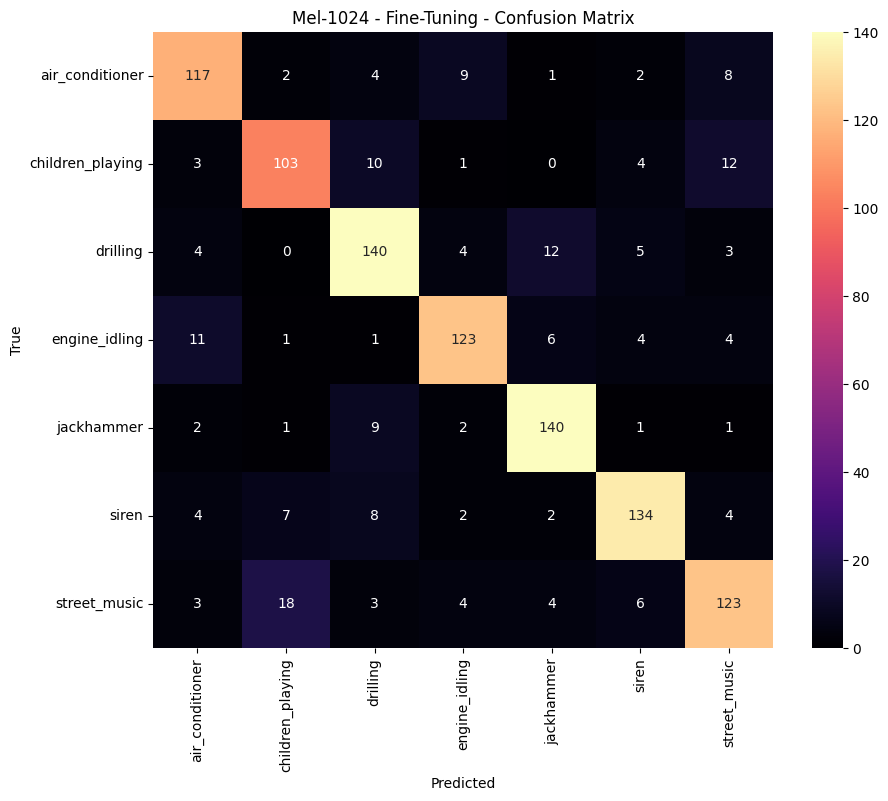

Tiempo Transfer Learning para Mel-1024: 575.15 segundos
Tiempo Fine-Tuning para Mel-1024: 990.69 segundos

Procesando representación: Mel-2048
Found 5365 files belonging to 7 classes.
Using 4292 files for training.
Found 5365 files belonging to 7 classes.
Using 1073 files for validation.
FLOPs para Mel-2048 (Transfer Learning): 147421488
Epoch 1/30
86/86 [==============================] - 46s 308ms/step - loss: 1.2072 - accuracy: 0.5697 - val_loss: 0.7527 - val_accuracy: 0.7512
Epoch 2/30
86/86 [==============================] - 21s 235ms/step - loss: 0.7920 - accuracy: 0.7279 - val_loss: 0.6311 - val_accuracy: 0.8006
Epoch 3/30
86/86 [==============================] - 21s 236ms/step - loss: 0.6505 - accuracy: 0.7759 - val_loss: 0.5648 - val_accuracy: 0.8201
Epoch 4/30
86/86 [==============================] - 21s 237ms/step - loss: 0.5652 - accuracy: 0.8001 - val_loss: 0.5392 - val_accuracy: 0.8052
Epoch 5/30
86/86 [==============================] - 21s 236ms/step - loss: 0.5111 - accu

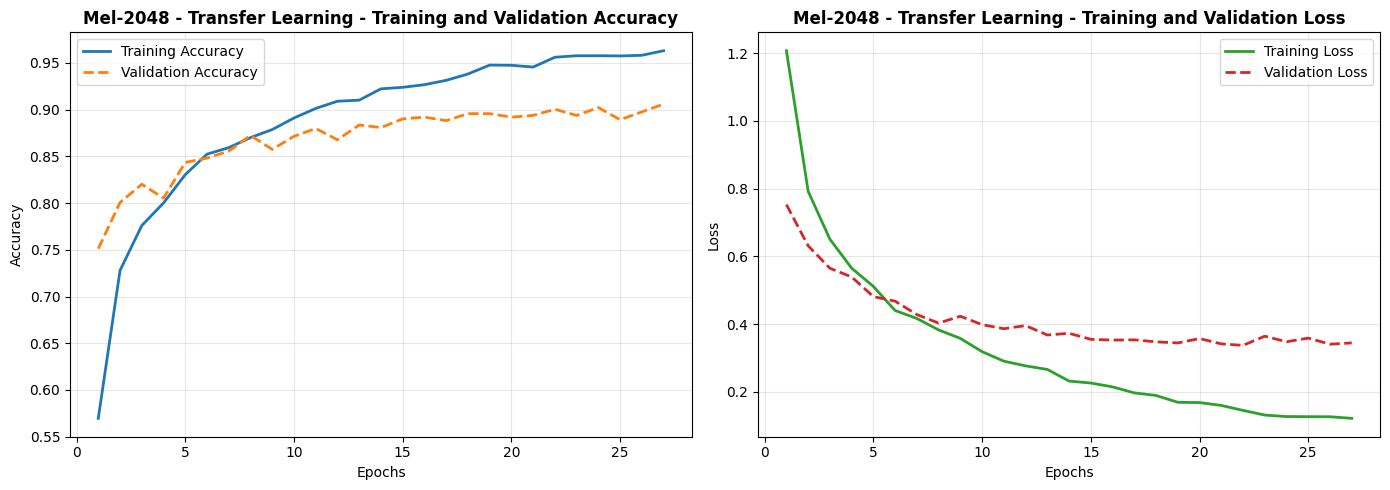

1/1 [==============================] - 0s 116ms/step

Reporte de Clasificación para Mel-2048 - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.88      0.93      0.90       143
children_playing       0.86      0.82      0.84       133
        drilling       0.91      0.87      0.89       169
   engine_idling       0.96      0.87      0.91       150
      jackhammer       0.92      0.97      0.94       157
           siren       0.89      0.94      0.92       161
    street_music       0.89      0.88      0.88       160

        accuracy                           0.90      1073
       macro avg       0.90      0.90      0.90      1073
    weighted avg       0.90      0.90      0.90      1073



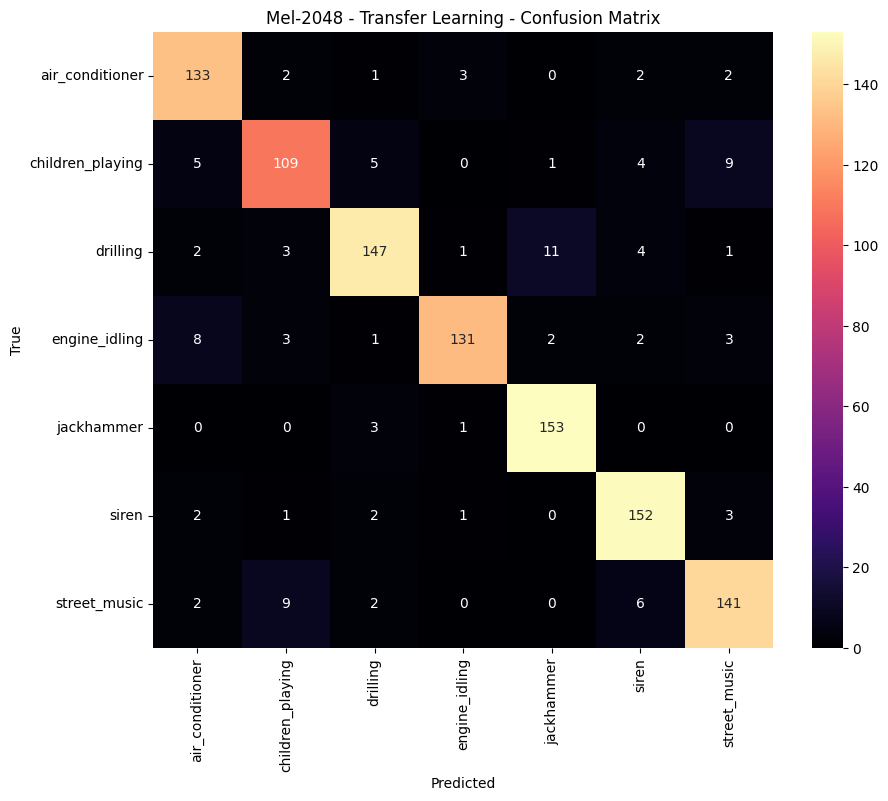

FLOPs para Mel-2048 (Fine-Tuning): 147421488
Epoch 1/60
86/86 [==============================] - 77s 563ms/step - loss: 6.5608 - accuracy: 0.3882 - val_loss: 1.8919 - val_accuracy: 0.6459
Epoch 2/60
86/86 [==============================] - 43s 485ms/step - loss: 1.4436 - accuracy: 0.6934 - val_loss: 1.1426 - val_accuracy: 0.7363
Epoch 3/60
86/86 [==============================] - 42s 484ms/step - loss: 0.6350 - accuracy: 0.8127 - val_loss: 0.9513 - val_accuracy: 0.7493
Epoch 4/60
86/86 [==============================] - 42s 484ms/step - loss: 0.3675 - accuracy: 0.8781 - val_loss: 0.8731 - val_accuracy: 0.7577
Epoch 5/60
86/86 [==============================] - 42s 485ms/step - loss: 0.2351 - accuracy: 0.9154 - val_loss: 0.8100 - val_accuracy: 0.7763
Epoch 6/60
86/86 [==============================] - 42s 482ms/step - loss: 0.1566 - accuracy: 0.9464 - val_loss: 0.7625 - val_accuracy: 0.7922
Epoch 7/60
86/86 [==============================] - 43s 487ms/step - loss: 0.1220 - accuracy: 0.9

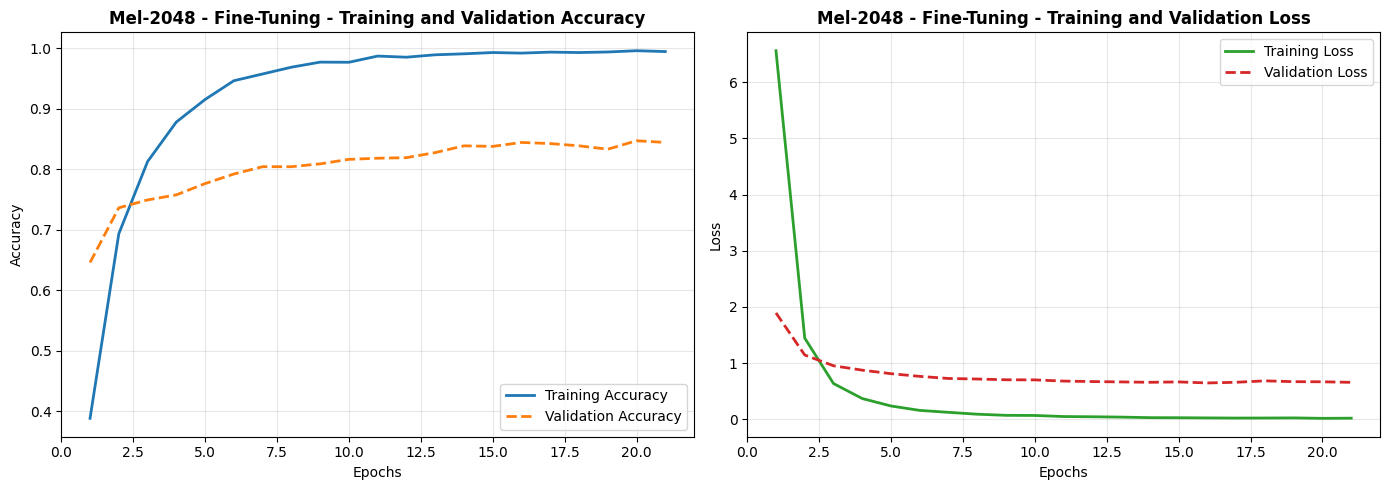

1/1 [==============================] - 0s 116ms/step

Reporte de Clasificación para Mel-2048 - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.85      0.90      0.87       143
children_playing       0.77      0.80      0.78       133
        drilling       0.83      0.86      0.85       169
   engine_idling       0.91      0.85      0.88       150
      jackhammer       0.86      0.90      0.88       157
           siren       0.91      0.85      0.88       161
    street_music       0.80      0.76      0.78       160

        accuracy                           0.85      1073
       macro avg       0.85      0.85      0.85      1073
    weighted avg       0.85      0.85      0.85      1073



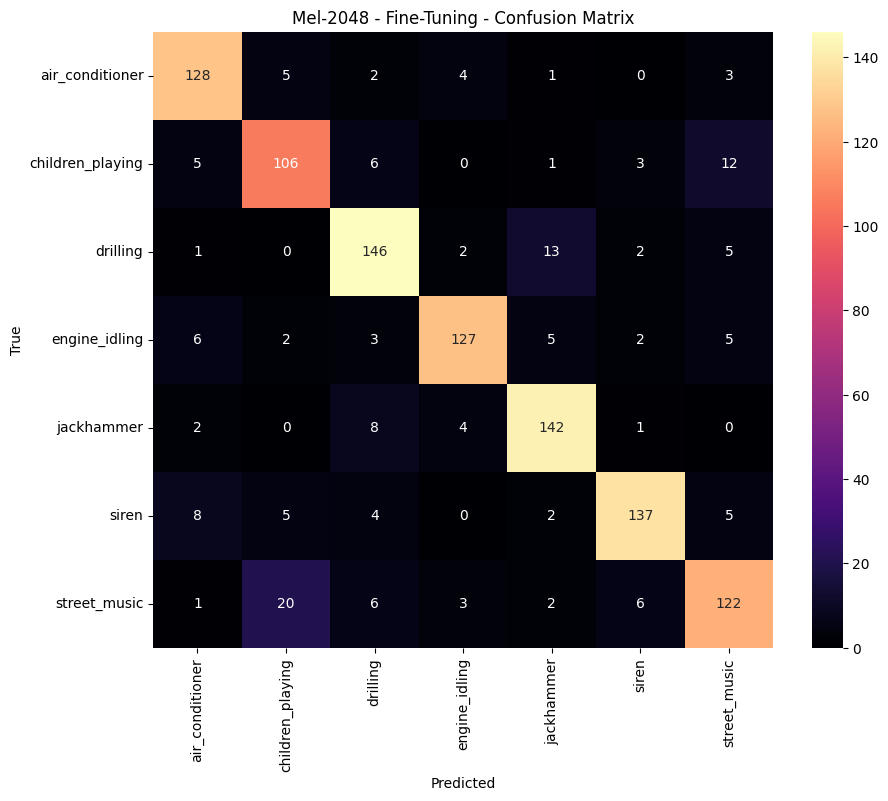

Tiempo Transfer Learning para Mel-2048: 635.38 segundos
Tiempo Fine-Tuning para Mel-2048: 1148.93 segundos

Procesando representación: Bump
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Bump (Transfer Learning): 147421488
Epoch 1/30
86/86 [==============================] - 54s 352ms/step - loss: 1.2799 - accuracy: 0.5221 - val_loss: 0.8821 - val_accuracy: 0.6959
Epoch 2/30
86/86 [==============================] - 23s 258ms/step - loss: 0.9258 - accuracy: 0.6655 - val_loss: 0.7938 - val_accuracy: 0.7295
Epoch 3/30
86/86 [==============================] - 24s 264ms/step - loss: 0.8019 - accuracy: 0.7019 - val_loss: 0.7057 - val_accuracy: 0.7621
Epoch 4/30
86/86 [==============================] - 24s 266ms/step - loss: 0.7194 - accuracy: 0.7347 - val_loss: 0.6555 - val_accuracy: 0.7715
Epoch 5/30
86/86 [==============================] - 23s 256ms/step - loss: 0.6425 - accuracy: 0

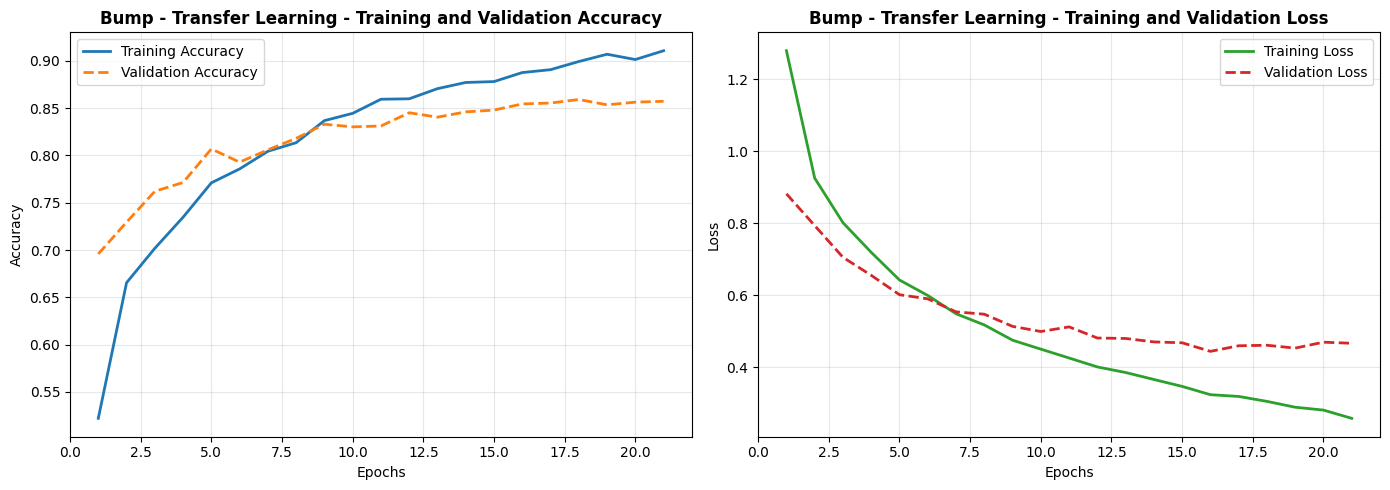

1/1 [==============================] - 0s 141ms/step

Reporte de Clasificación para Bump - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.83      0.90      0.86       143
children_playing       0.77      0.83      0.80       133
        drilling       0.91      0.85      0.88       168
  engine_idiling       0.84      0.87      0.86       149
      jackhammer       0.91      0.93      0.92       157
           siren       0.87      0.88      0.87       161
    street_music       0.83      0.73      0.78       161

        accuracy                           0.85      1072
       macro avg       0.85      0.85      0.85      1072
    weighted avg       0.86      0.85      0.85      1072



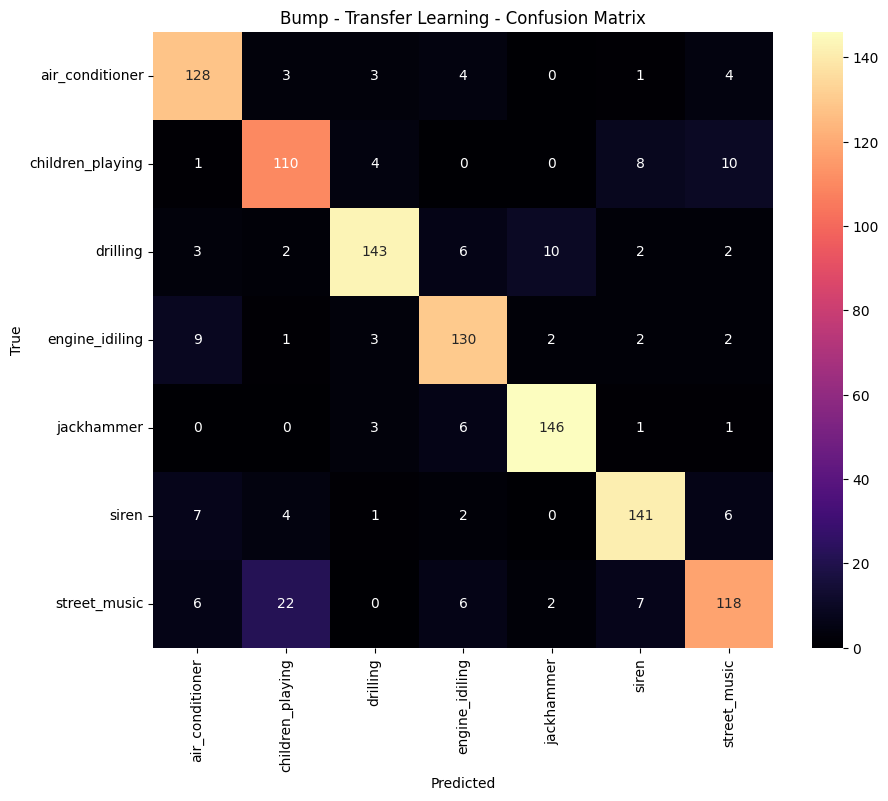

FLOPs para Bump (Fine-Tuning): 147421488
Epoch 1/60
86/86 [==============================] - 79s 582ms/step - loss: 4.5857 - accuracy: 0.3839 - val_loss: 1.2771 - val_accuracy: 0.6035
Epoch 2/60
86/86 [==============================] - 44s 503ms/step - loss: 1.0275 - accuracy: 0.6280 - val_loss: 1.1709 - val_accuracy: 0.6045
Epoch 3/60
86/86 [==============================] - 44s 502ms/step - loss: 0.7012 - accuracy: 0.7536 - val_loss: 0.9512 - val_accuracy: 0.6744
Epoch 4/60
86/86 [==============================] - 44s 500ms/step - loss: 0.5109 - accuracy: 0.8240 - val_loss: 0.7827 - val_accuracy: 0.7313
Epoch 5/60
86/86 [==============================] - 44s 498ms/step - loss: 0.3629 - accuracy: 0.8734 - val_loss: 0.6895 - val_accuracy: 0.7752
Epoch 6/60
86/86 [==============================] - 44s 501ms/step - loss: 0.2677 - accuracy: 0.9126 - val_loss: 0.6785 - val_accuracy: 0.7817
Epoch 7/60
86/86 [==============================] - 44s 498ms/step - loss: 0.1858 - accuracy: 0.9399 

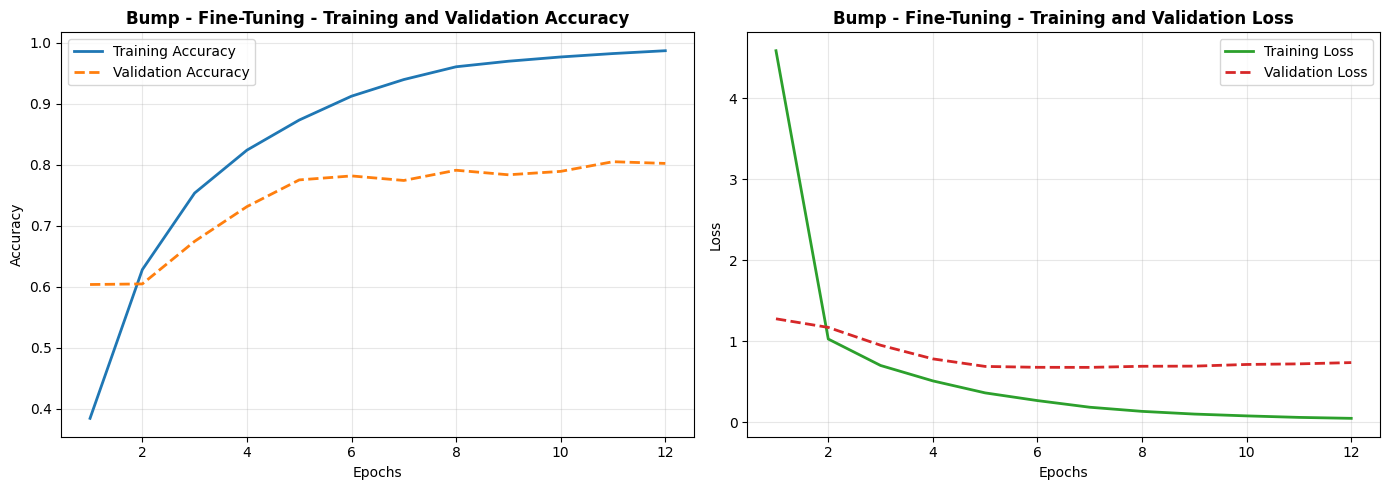

1/1 [==============================] - 0s 120ms/step

Reporte de Clasificación para Bump - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.74      0.81      0.78       143
children_playing       0.66      0.65      0.66       133
        drilling       0.80      0.82      0.81       168
  engine_idiling       0.76      0.78      0.77       149
      jackhammer       0.91      0.82      0.87       157
           siren       0.83      0.83      0.83       161
    street_music       0.70      0.69      0.69       161

        accuracy                           0.77      1072
       macro avg       0.77      0.77      0.77      1072
    weighted avg       0.78      0.77      0.77      1072



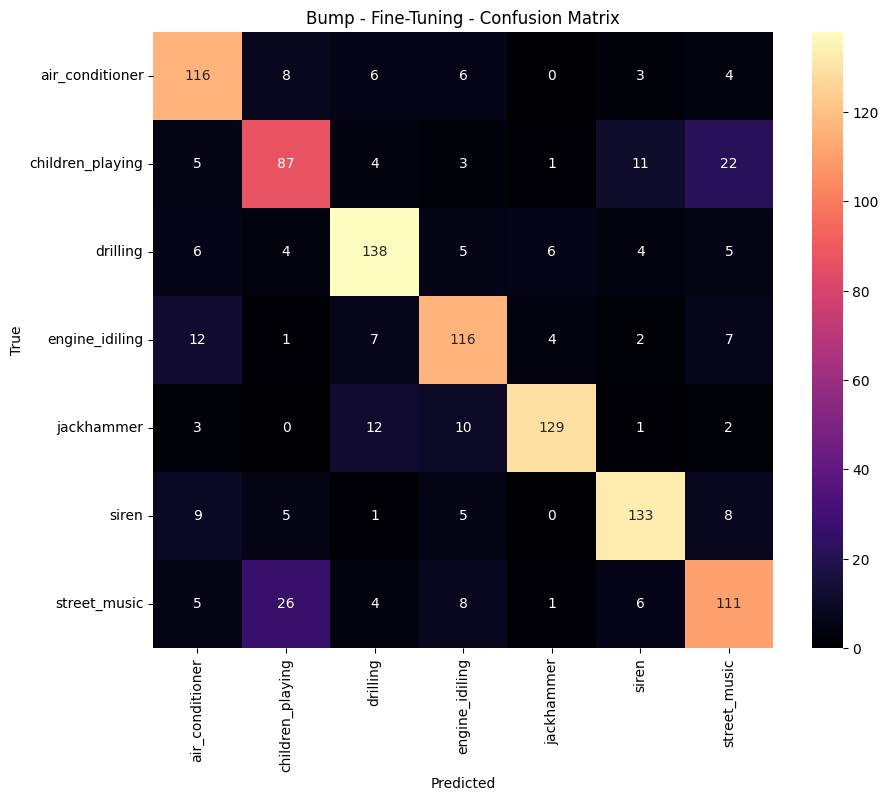

Tiempo Transfer Learning para Bump: 611.33 segundos
Tiempo Fine-Tuning para Bump: 741.91 segundos

Procesando representación: Morlet
Found 5362 files belonging to 7 classes.
Using 4290 files for training.
Found 5362 files belonging to 7 classes.
Using 1072 files for validation.
FLOPs para Morlet (Transfer Learning): 147421488
Epoch 1/30
86/86 [==============================] - 47s 329ms/step - loss: 1.3519 - accuracy: 0.4804 - val_loss: 0.9898 - val_accuracy: 0.6362
Epoch 2/30
86/86 [==============================] - 24s 259ms/step - loss: 0.9794 - accuracy: 0.6359 - val_loss: 0.8924 - val_accuracy: 0.6810
Epoch 3/30
86/86 [==============================] - 24s 267ms/step - loss: 0.8530 - accuracy: 0.6900 - val_loss: 0.7852 - val_accuracy: 0.7239
Epoch 4/30
86/86 [==============================] - 24s 266ms/step - loss: 0.7689 - accuracy: 0.7235 - val_loss: 0.7285 - val_accuracy: 0.7425
Epoch 5/30
86/86 [==============================] - 24s 268ms/step - loss: 0.7229 - accuracy: 0.7420

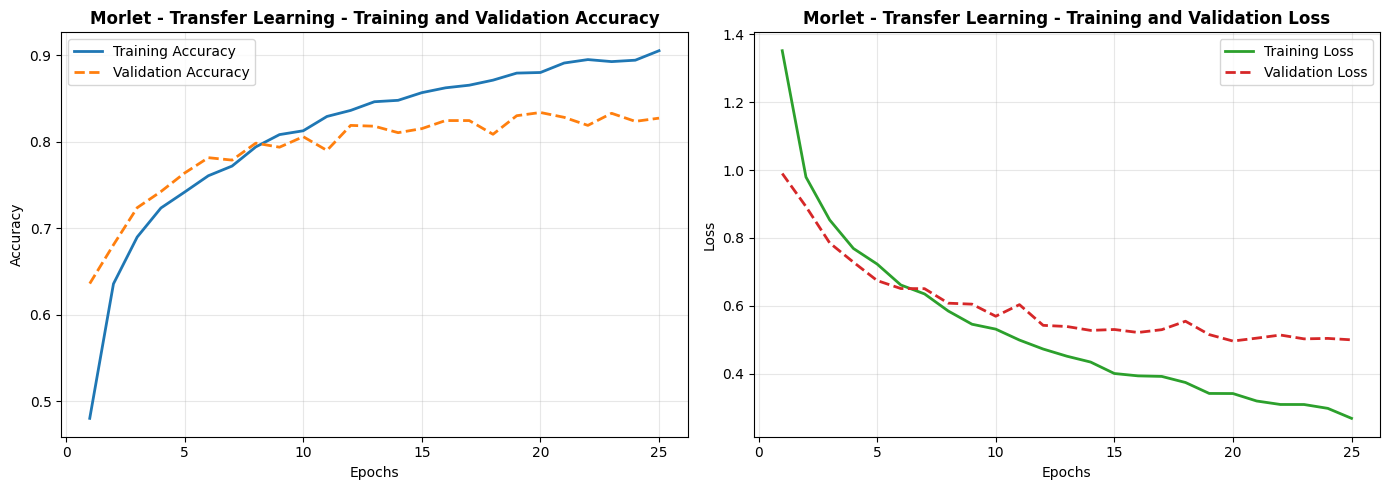

1/1 [==============================] - 0s 120ms/step

Reporte de Clasificación para Morlet - Transfer Learning:

                  precision    recall  f1-score   support

 air_conditioner       0.83      0.85      0.84       143
children_playing       0.68      0.75      0.71       133
        drilling       0.78      0.89      0.83       168
  engine_idiling       0.88      0.85      0.86       149
      jackhammer       0.91      0.90      0.91       157
           siren       0.93      0.86      0.89       161
    street_music       0.83      0.72      0.77       161

        accuracy                           0.83      1072
       macro avg       0.83      0.83      0.83      1072
    weighted avg       0.84      0.83      0.83      1072



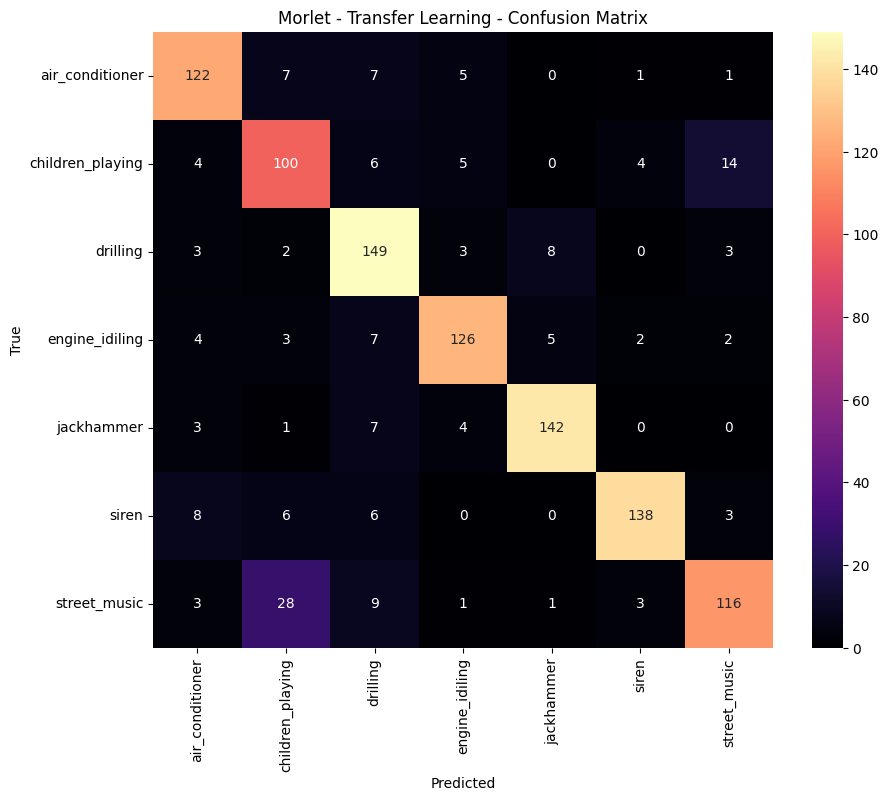

FLOPs para Morlet (Fine-Tuning): 147421488
Epoch 1/60
86/86 [==============================] - 81s 565ms/step - loss: 5.8664 - accuracy: 0.3830 - val_loss: 1.6738 - val_accuracy: 0.5522
Epoch 2/60
86/86 [==============================] - 43s 488ms/step - loss: 1.1093 - accuracy: 0.6049 - val_loss: 1.4915 - val_accuracy: 0.5252
Epoch 3/60
86/86 [==============================] - 43s 489ms/step - loss: 0.8074 - accuracy: 0.7163 - val_loss: 1.0726 - val_accuracy: 0.6119
Epoch 4/60
86/86 [==============================] - 43s 489ms/step - loss: 0.6011 - accuracy: 0.7881 - val_loss: 0.9077 - val_accuracy: 0.6903
Epoch 5/60
86/86 [==============================] - 43s 489ms/step - loss: 0.4440 - accuracy: 0.8401 - val_loss: 0.8592 - val_accuracy: 0.7136
Epoch 6/60
86/86 [==============================] - 43s 488ms/step - loss: 0.3361 - accuracy: 0.8867 - val_loss: 0.8515 - val_accuracy: 0.7313
Epoch 7/60
86/86 [==============================] - 43s 494ms/step - loss: 0.2408 - accuracy: 0.921

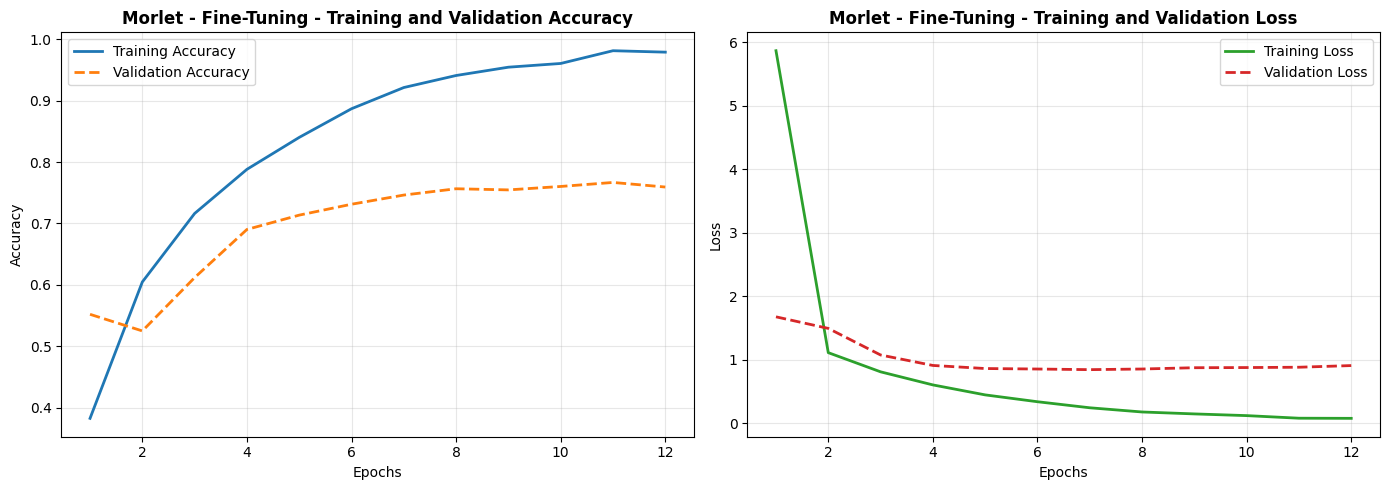

1/1 [==============================] - 0s 148ms/step

Reporte de Clasificación para Morlet - Fine-Tuning:

                  precision    recall  f1-score   support

 air_conditioner       0.72      0.74      0.73       143
children_playing       0.59      0.66      0.62       133
        drilling       0.72      0.82      0.77       168
  engine_idiling       0.78      0.68      0.73       149
      jackhammer       0.83      0.81      0.82       157
           siren       0.91      0.79      0.85       161
    street_music       0.68      0.69      0.68       161

        accuracy                           0.74      1072
       macro avg       0.75      0.74      0.74      1072
    weighted avg       0.75      0.74      0.75      1072



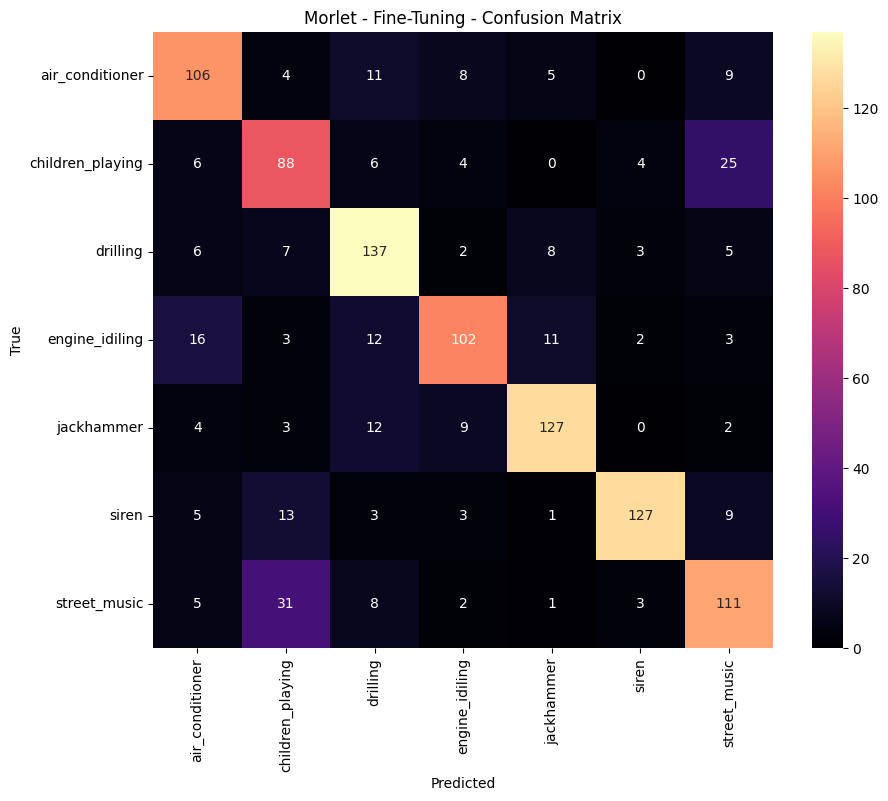

Tiempo Transfer Learning para Morlet: 702.34 segundos
Tiempo Fine-Tuning para Morlet: 656.75 segundos


In [16]:
# Iterar sobre cada representación
for representation, data_path in data_paths.items():
    print(f"\nProcesando representación: {representation}")

    # Cargar datos
    train_ds, val_ds, class_names = load_and_preprocess_data(data_path)
    num_classes = len(class_names)

    # Crear modelo base
    model = create_model(num_classes)

    # Medir carga computacional antes de Transfer Learning
    cpu_usages_tl, memory_usages_tl = [], []
    cpu_usages_ft, memory_usages_ft = [], []

    # **TRANSFER LEARNING**
    start_time_tl = time.time()

    # Medición de carga computacional antes del entrenamiento TL
    cpu, memory = measure_system_load()
    cpu_usages_tl.append(cpu)
    memory_usages_tl.append(memory)

    # Calcular FLOPs antes de TL
    flops_tl = get_flops(model)
    print(f"FLOPs para {representation} (Transfer Learning): {flops_tl}")

    # Entrenar con Transfer Learning
    history = train_model(model, train_ds, val_ds)
    plot_training_history(history, title=f"{representation} - Transfer Learning")

    # Medir tiempo final de TL
    end_time_tl = time.time()
    total_time_tl = end_time_tl - start_time_tl

    # Reporte de métricas
    report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Transfer Learning")

    # Guardar resultados TL
    final_results.append({
        "Representation": representation,
        "Stage": "Transfer Learning",
        "Accuracy": report["accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"],
        "FLOPs": flops_tl
    })

    # **FINE-TUNING**
    start_time_ft = time.time()

    # Medición de carga computacional antes del Fine-Tuning
    cpu, memory = measure_system_load()
    cpu_usages_ft.append(cpu)
    memory_usages_ft.append(memory)

    # Recalcular FLOPs si se desbloquean capas en Fine-Tuning
    flops_ft = get_flops(model)
    print(f"FLOPs para {representation} (Fine-Tuning): {flops_ft}")

    # Entrenar con Fine-Tuning
    fine_tune_history = fine_tune_model(model, train_ds, val_ds)
    plot_training_history(fine_tune_history, title=f"{representation} - Fine-Tuning")

    # Medir tiempo final de FT
    end_time_ft = time.time()
    total_time_ft = end_time_ft - start_time_ft

    # Reporte de métricas Fine-Tuning
    fine_tune_report = generate_classification_report(model, val_ds, class_names, title=f"{representation} - Fine-Tuning")

    # Guardar resultados FT
    final_results.append({
        "Representation": representation,
        "Stage": "Fine-Tuning",
        "Accuracy": fine_tune_report["accuracy"],
        "Macro F1": fine_tune_report["macro avg"]["f1-score"],
        "Weighted F1": fine_tune_report["weighted avg"]["f1-score"],
        "FLOPs": flops_ft
    })

    # Guardar modelo
    model.save(f"model_{representation}.keras")

    # Guardar tiempos de entrenamiento separados
    training_times.append({
        "Representation": representation,
        "Time TL (seconds)": total_time_tl,
        "Time FT (seconds)": total_time_ft
    })

    print(f"Tiempo Transfer Learning para {representation}: {total_time_tl:.2f} segundos")
    print(f"Tiempo Fine-Tuning para {representation}: {total_time_ft:.2f} segundos")

    # Guardar carga computacional separada por TL y FT
    computational_load.append({
        "Representation": representation,
        "CPU_TL (avg)": sum(cpu_usages_tl) / len(cpu_usages_tl),
        "Memory_TL (avg)": sum(memory_usages_tl) / len(memory_usages_tl),
        "CPU_FT (avg)": sum(cpu_usages_ft) / len(cpu_usages_ft),
        "Memory_FT (avg)": sum(memory_usages_ft) / len(memory_usages_ft),
    })

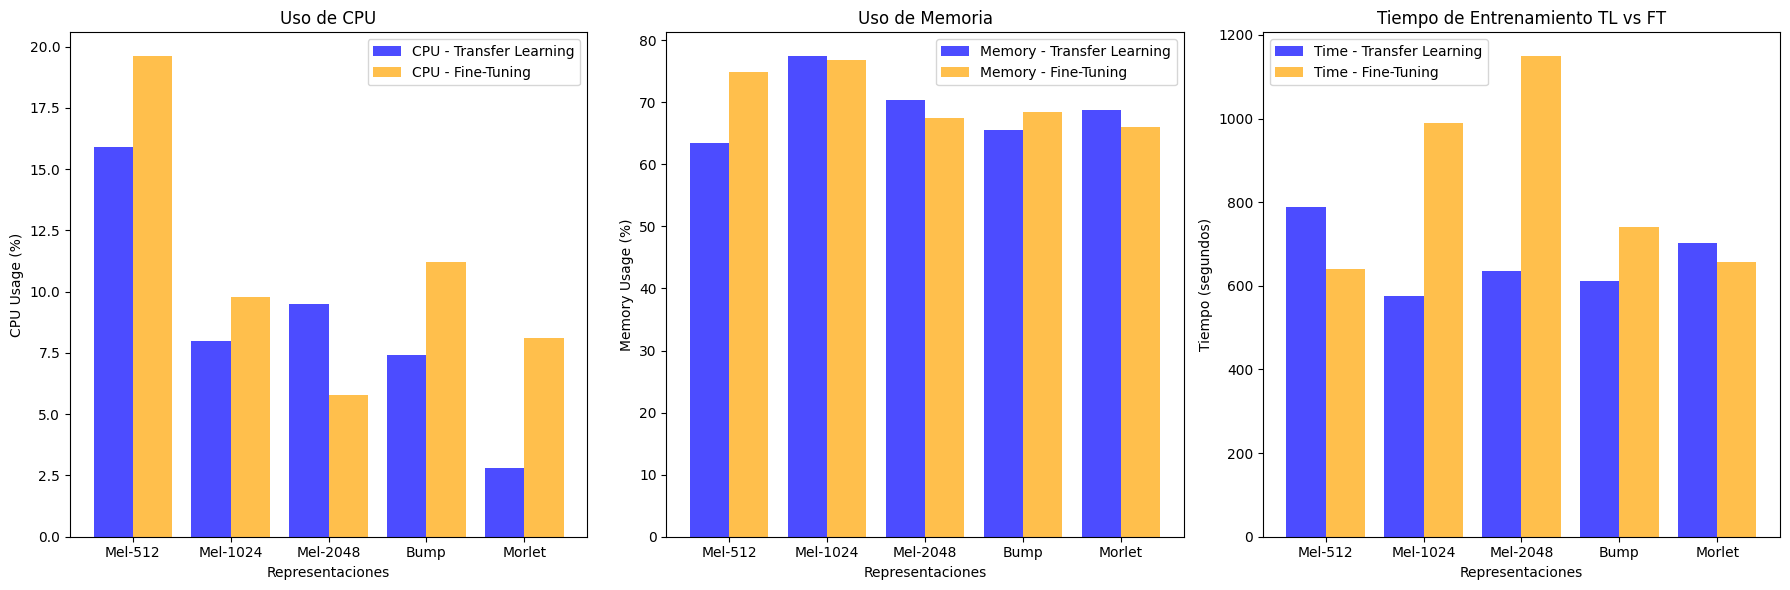

In [17]:
# **Gráficos de carga computacional y tiempos**
representations = [entry["Representation"] for entry in computational_load]
cpu_tl = [entry["CPU_TL (avg)"] for entry in computational_load]
memory_tl = [entry["Memory_TL (avg)"] for entry in computational_load]
cpu_ft = [entry["CPU_FT (avg)"] for entry in computational_load]
memory_ft = [entry["Memory_FT (avg)"] for entry in computational_load]
times_tl = [entry["Time TL (seconds)"] for entry in training_times]
times_ft = [entry["Time FT (seconds)"] for entry in training_times]

# Definir el tamaño de la figura
plt.figure(figsize=(18, 6))
 
# Crear posiciones para las barras
bar_width = 0.4
x_pos = range(len(representations))
 
# **Gráfico de Uso de CPU**
plt.subplot(1, 3, 1)
plt.bar(x_pos, cpu_tl, width=bar_width, label="CPU - Transfer Learning", color="blue", alpha=0.7)
plt.bar([x + bar_width for x in x_pos], cpu_ft, width=bar_width, label="CPU - Fine-Tuning", color="orange", alpha=0.7)
plt.ylabel('CPU Usage (%)')
plt.xlabel('Representaciones')
plt.xticks([x + bar_width / 2 for x in x_pos], representations)
plt.title('Uso de CPU')
plt.legend()
 
# **Gráfico de Uso de Memoria**
plt.subplot(1, 3, 2)
plt.bar(x_pos, memory_tl, width=bar_width, label="Memory - Transfer Learning", color="blue", alpha=0.7)
plt.bar([x + bar_width for x in x_pos], memory_ft, width=bar_width, label="Memory - Fine-Tuning", color="orange", alpha=0.7)
plt.ylabel('Memory Usage (%)')
plt.xlabel('Representaciones')
plt.xticks([x + bar_width / 2 for x in x_pos], representations)
plt.title('Uso de Memoria')
plt.legend()
 
# **Gráfico de Tiempos de Entrenamiento**
plt.subplot(1, 3, 3)
plt.bar(x_pos, times_tl, width=bar_width, label="Time - Transfer Learning", color="blue", alpha=0.7)
plt.bar([x + bar_width for x in x_pos], times_ft, width=bar_width, label="Time - Fine-Tuning", color="orange", alpha=0.7)
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Representaciones')
plt.xticks([x + bar_width / 2 for x in x_pos], representations)
plt.title('Tiempo de Entrenamiento TL vs FT')
plt.legend()
 
plt.tight_layout()
plt.show()


In [18]:
# Crear DataFrame consolidado
df_results = pd.DataFrame(final_results)
# Mostrar el reporte completo
print("\n**Reporte Consolidado:**\n")
print(df_results)

# Calcular puntaje combinado (promedio de todas las métricas)
df_results["Average Score"] = df_results[["Accuracy", "Macro F1", "Weighted F1"]].mean(axis=1)

# Determinar el mejor modelo en base al puntaje combinado
best_model = df_results.sort_values(by="Average Score", ascending=False).iloc[0]

# Mostrar el mejor modelo
print("\n**Mejor Representación (Basado en Todas las Métricas):**")
print(best_model)


**Reporte Consolidado:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1  \
0        Mel-512  Transfer Learning  0.875933  0.875675     0.876197   
1        Mel-512        Fine-Tuning  0.729478  0.729777     0.728917   
2       Mel-1024  Transfer Learning  0.882463  0.882657     0.882439   
3       Mel-1024        Fine-Tuning  0.820896  0.819871     0.820646   
4       Mel-2048  Transfer Learning  0.900280  0.898692     0.899853   
5       Mel-2048        Fine-Tuning  0.846226  0.845321     0.846185   
6           Bump  Transfer Learning  0.854478  0.852936     0.854032   
7           Bump        Fine-Tuning  0.774254  0.771881     0.774711   
8         Morlet  Transfer Learning  0.833022  0.831386     0.833664   
9         Morlet        Fine-Tuning  0.744403  0.742918     0.746269   

       FLOPs  
0  147421488  
1  147421488  
2  147421488  
3  147421488  
4  147421488  
5  147421488  
6  147421488  
7  147421488  
8  147421488  
9  147421488  

**Mejor Repres

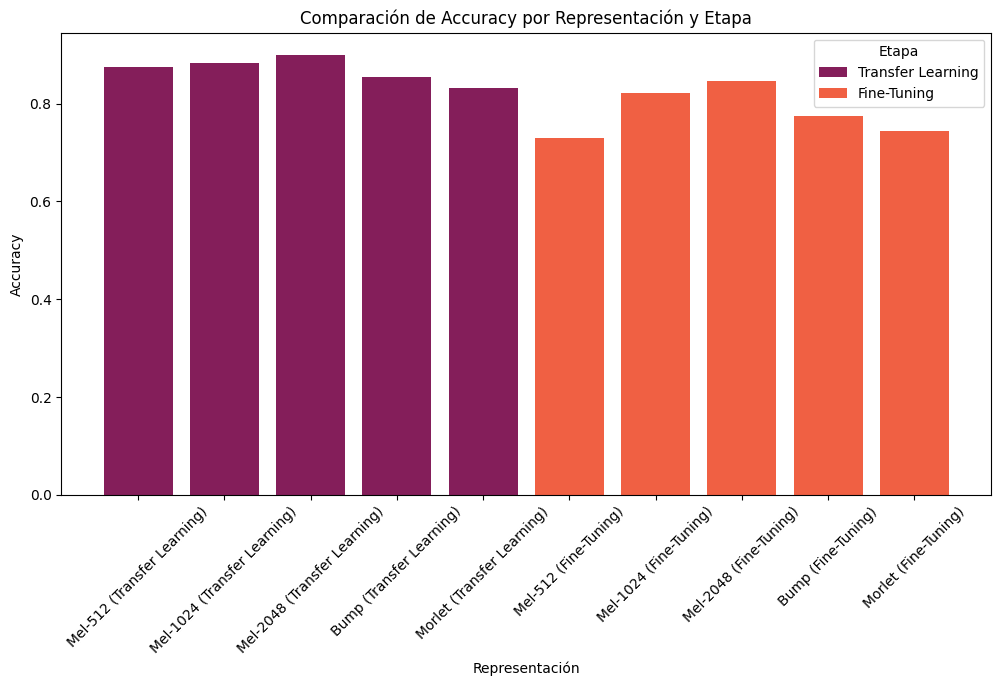

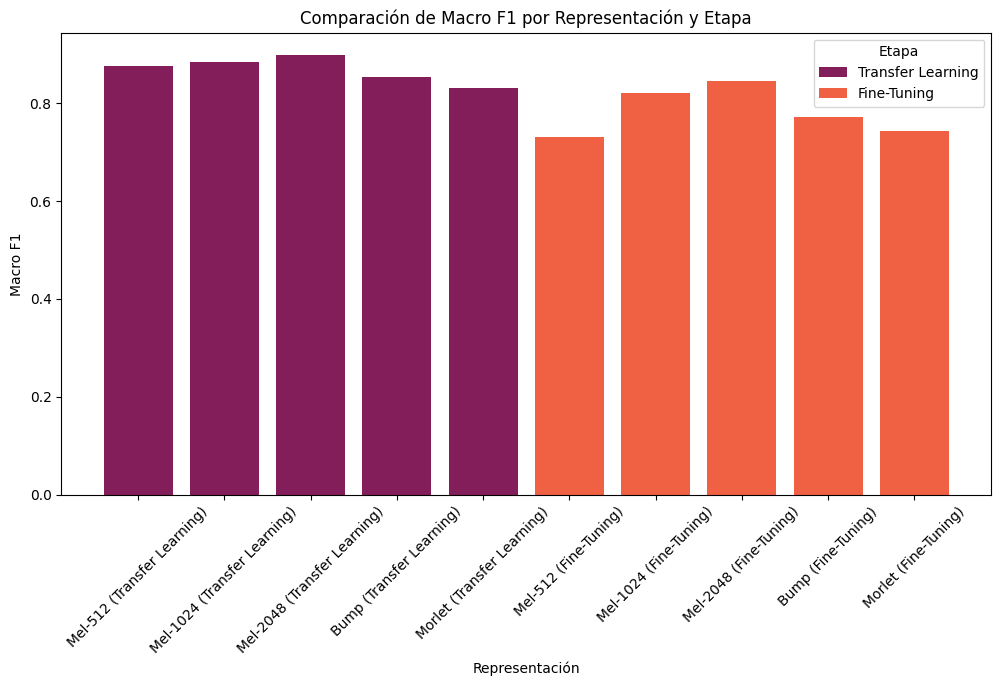

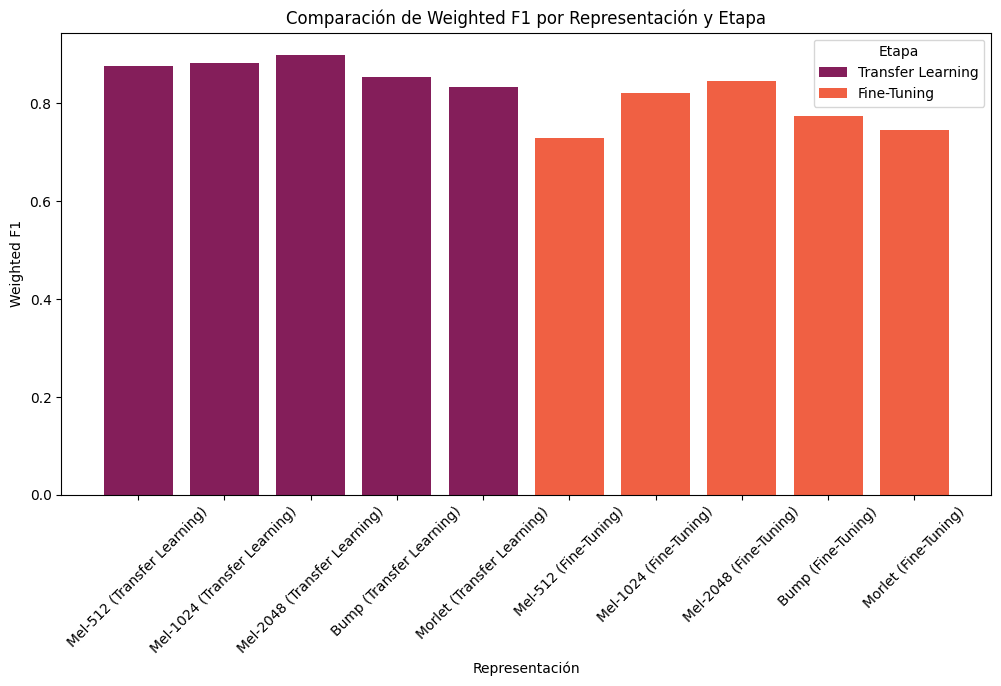

In [19]:
# Gráficos comparativos por métrica

colors = sns.color_palette("rocket", n_colors=len(df_results["Stage"].unique()))

metrics = ["Accuracy", "Macro F1", "Weighted F1"]
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for i, stage in enumerate(df_results["Stage"].unique()):
        stage_data = df_results[df_results["Stage"] == stage]
        plt.bar(stage_data["Representation"] + f" ({stage})", stage_data[metric], 
                label=stage, color=colors[i])  # Aplicando color personalizado

    plt.title(f"Comparación de {metric} por Representación y Etapa")
    plt.xlabel("Representación")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title="Etapa")
    plt.show()

In [20]:
# Ordenar resultados por puntaje promedio
df_results_sorted = df_results.sort_values(by="Average Score", ascending=False)

# Mostrar la tabla final ordenada
print("\n**Tabla de Resultados Ordenada por Puntaje Promedio:**\n")
print(df_results_sorted)


**Tabla de Resultados Ordenada por Puntaje Promedio:**

  Representation              Stage  Accuracy  Macro F1  Weighted F1  \
4       Mel-2048  Transfer Learning  0.900280  0.898692     0.899853   
2       Mel-1024  Transfer Learning  0.882463  0.882657     0.882439   
0        Mel-512  Transfer Learning  0.875933  0.875675     0.876197   
6           Bump  Transfer Learning  0.854478  0.852936     0.854032   
5       Mel-2048        Fine-Tuning  0.846226  0.845321     0.846185   
8         Morlet  Transfer Learning  0.833022  0.831386     0.833664   
3       Mel-1024        Fine-Tuning  0.820896  0.819871     0.820646   
7           Bump        Fine-Tuning  0.774254  0.771881     0.774711   
9         Morlet        Fine-Tuning  0.744403  0.742918     0.746269   
1        Mel-512        Fine-Tuning  0.729478  0.729777     0.728917   

       FLOPs  Average Score  
4  147421488       0.899608  
2  147421488       0.882520  
0  147421488       0.875935  
6  147421488       0.853815  


In [21]:
from pprint import pformat

with open("resultadosResnet101.txt", "w") as archivo:
    archivo.write("=== Resultados Finales ===\n")
    archivo.write(pformat(final_results, indent=4))
    
    archivo.write("\n\n=== Carga Computacional ===\n")
    archivo.write(pformat(computational_load, indent=4))
    
    archivo.write("\n\n=== Tiempos de Entrenamiento ===\n")
    archivo.write(pformat(training_times, indent=4))
    archivo.write("=== Resultados de metricas de precision ===\n")
    archivo.write(pformat(df_results, indent=4))